# <center> Test Engineer
## <center> Current adjustment simulator for IC testing
***
Autora: Daniela Feoli Grant<br>
Creación: 09.01.2024<br>

Versión 2 -- Cambios:
- Se agregaron variables para poder crear el objeto AlegroIC seleccionando también el límite inferior y superior de las corrientes de entrada, el valor que ajusta cada bit del registro (step), y la cantidad de bits del registro.
- Se cambió el algoritmo para calcular el registro deseado: se calcula el cociente de la diferencia entre la corriente inicial y la corriente deseada y el valor que ajusta cada bit del registro (step)
- Se cambió la forma de guardar los datos en el CSV para utilizar data frames de Pandas

El siguiente código simula la funcionalidad de los IC de Allegro para ajustar
la corriente.

In [350]:
import random
import matplotlib.pyplot as plt
import pandas as pd

### Clase AllegroIC
- Recibe como argumentos los siguientes, de manera que sea customizable dependiendo de las características del chip a testear:
    - **targ_current**: (float) es la corriente final a la cual se quiere llegar
    - **min_in**: (float) el valor mínimo de posibles corrientes de entrada
    - **max_in**: (float) el valor máximo de posibles corrientes de entrada
    - **step**: (float) el valor de corriente que ajusta cada bit del registro
    - **reg_bits**: (int) la cantidad de bits que componen el registro
- Contiene un método:
    - **adjust_I** se encarga de ajustar el valor de corriente lo más cercano posible a *targ_current* y va actualizando el registro *reg*.
        - Argumentos:
            - *seed*: funciona de semilla para generar algún valor aleatorio de corriente inicial acotado entre *min_in* y *max_in*
        - Retorno:
            - *current_init*: corriente inicial
            - *current*: corriente final
            - *reg*: valor del registro


In [351]:
class AllegroIC:
    def __init__(self, targ_current:float, min_in:float, max_in:float, step:float, reg_bits:int):
        self.targ_current = targ_current
        self.min_in = min_in
        self.max_in = max_in
        self.step = step
        self.reg_bits = reg_bits
        
    def __str__(self):
        return f"Target current is: {self.targ_current}."

    def adjust_I(self, seed:int):
        self.seed = random.seed(seed)                                       # Utiliza semillas para generar los valores aleatorios
        current_init = random.uniform(self.min_in, self.max_in)             # Crea valores pseudo-aleatorios entre min_in y max_in
        current_diff = self.targ_current - current_init
        current = 0
        reg = 0

        #print("La corriente inicial es de",current_init)

        if -self.step/2 < current_diff < self.step/2:                       # Valor default del registro es 0. Caso en el que no es necesario ajustar corriente.         
            reg = 0
            current = current_init

        elif current_diff <= -self.step/2:                                  # Caso en el que es necesario restar corriente 
            reg = round(abs(current_diff) / self.step, 0) + (self.reg_bits/2 - 1)

            if reg >= self.reg_bits:                                        # Define el máximo ajuste posible
                reg = self.reg_bits - 1

            current = current_init - (reg - (self.reg_bits/2 - 1)) * self.step
            #print("La corriente final es de",current," A.\nEl registro es:", reg)

        elif current_diff >= self.step/2:                                   # Caso en el que es necesario sumar corriente 
            reg = round(abs(current_diff) / self.step, 0)
            
            if reg >= self.reg_bits/2:                                      # Define el máximo ajuste posible
                reg = self.reg_bits/2 - 1

            current = current_init + (reg * self.step)
            #print("La corriente final es de",current," A.\nEl registro es:", reg)

        return current_init, current, reg
        
        

    

Se instancia un objeto de la clase AllegroIC con una corriente deseada de 2.5 uA y que utilice un rango de 1 uA a 5 uA. Tiene un registro de 16 bits, en el que cada bit actualiza 0.1 uA. Del mismo modo, se crea un arreglo *seed_arr* que contiene 10k semillas para probar valores aleatorios de corriente inicial.

In [352]:
aic1 = AllegroIC(targ_current=2.5e-6, min_in=1e-6, max_in=5e-6, step=0.1e-6, reg_bits=16) 
seed_arr = range(0,9999,1)                  # Creación de 10000 semillas para generar los valores aleatorios de corriente de entrada
filename = 'datos'                          # Nombre que se le dará al CSV

Se itera el método de adjust_I para todas las semillas. Se puede observar el resultado en terminal así como proceder a abrir el CSV creado en carpeta.

In [353]:
init_arr = []
current_arr = []
reg_arr = []

for i in seed_arr:                                                          # Iteración para ajustar la corriente para cada semilla
    [init,current,reg]=aic1.adjust_I(i)
    init_arr.append(init)
    current_arr.append(current)
    reg_arr.append(int(reg))

data = list(zip(init_arr,current_arr,reg_arr))                              # Crea un tuple de las listas generadas en la iteración para poder pasarlo a dataframe
df = pd.DataFrame(data,
                  columns = ['Corriente inicial (A)','Corriente final (A)','Valor del registro (decimal)'])

df.to_csv(filename+'.csv')


## Resultados
Se grafican los histogramas en donde se observa con claridad los valores de corriente ajustados alrededor de 2.5 uA.

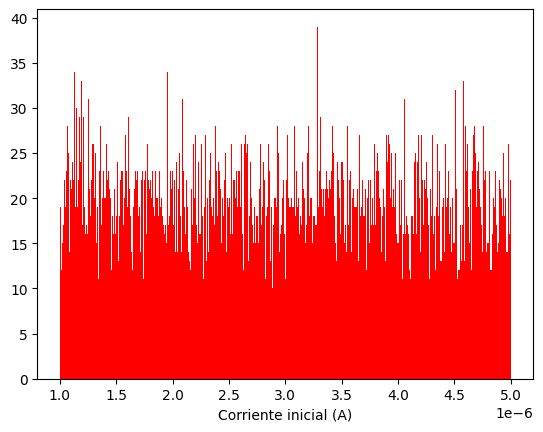

In [354]:
plt.hist(init_arr,color='r',bins=500)
plt.xlabel('Corriente inicial (A)')
plt.show()


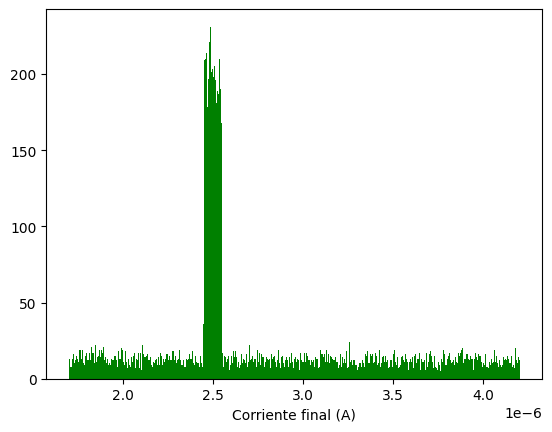

In [355]:
plt.hist(current_arr,color='g',bins=500)
plt.xlabel('Corriente final (A)')
plt.show()

El CSV muestra los siguientes datos:

In [356]:
pd.options.display.float_format = '{:.9f}'.format
df = pd.read_csv(filename+'.csv')
df.head(10)

,Unnamed: 0,Corriente inicial (A),Corriente final (A),Valor del registro (decimal)
0,0,0.000004378,0.000003578,15
1,1,0.000001537,0.000002237,7
2,2,0.000004824,0.000004024,15
3,3,0.000001952,0.000002452,5
4,4,0.000001944,0.000002544,6
5,5,0.000003492,0.000002692,15
6,6,0.000004173,0.000003373,15
7,7,0.000002295,0.000002495,2
8,8,0.000001907,0.000002507,6
9,9,0.000002852,0.000002452,11
